# Kmapper script for all pools

## Import libraries

In [8]:
import kmapper as km
from kmapper.plotlyviz import *

import sklearn
#from sklearn import ensemble
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
# from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# scipy for interpolation
# import scipy 
# from scipy.interpolate import *
import hdbscan
import pickle as pk
import json as js
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

# Plotly and Dash
import plotly.graph_objs as go
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
from ipywidgets import (HBox, VBox)
import dash_html_components as html
import dash_core_components as dcc
import dash
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
warnings.filterwarnings("ignore")

## Upload data

In [9]:
import pandas as pd
water20 = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")

## Standardize data

In [10]:
water20[["WDP", "SECCHI", "TEMP", "DO", "TURB",
             "VEL", "TP", "TN", "SS", "CHLcal"]]
            
continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB",
             "VEL", "TP", "TN", "SS", "CHLcal"]

water_df = ColumnTransformer(['somename', StandardScaler(), continuous_variables], remainder = 'passthrough')

# n_data = watershort.shape[0]
n_data = water20.shape[0]

water_df = pd.DataFrame(water_df, columns = ["WDP", "SECCHI", "TEMP", "DO", "TURB",
                             "VEL", "TP", "TN", "SS", "CHLcal"])     

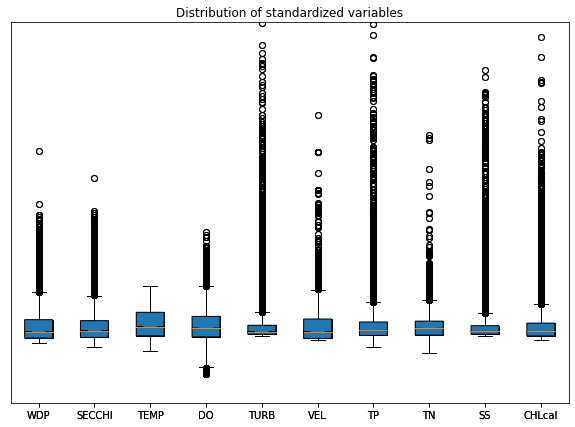

In [11]:
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(water_df)
ax = fig.add_subplot(111)

bp = ax.boxplot(water_df, patch_artist = True,
                notch ='True', vert = 1)

ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
                    "WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"])

ax.set_ylim(-5, 20)
ax.get_yaxis().set_visible(False)

#ax.set_yticklables([-5, 0, 5, 10, 15, 20])

plt.title("Distribution of standardized variables")
 
# show plot
plt.show(bp)

## Kmapper function

In [22]:
def mapper_func_hdb(df, HDB_MIN_CLUSTER = 45, HDB_MIN_SAMP = 10, 
                    N_CUBES = [10,10], PERC_OVERLAP = [.25,.25], draw_bool = True):
    """
    """
    X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]

    # for discerning primary variables in PCA 
    continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", 
                            "VEL", "TP", "TN", "SS", "CHLcal"]
    
    
    var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
    projected_vars = continuous_variables
    projected_var_indices = [var_to_index[var] for var in projected_vars]
    
#     if X.shape[0]<10:
#         #print(X)
#         print("Not enough data in ", title, "_size = ", X.shape[0])
#         return(X.shape[0])
    
    # to match up indices in scomplex with the original dataframe X
    X.reset_index(drop = True, inplace = True) 
    
    # create instance of clustering alg
    cluster_alg = hdbscan.HDBSCAN(min_cluster_size = HDB_MIN_CLUSTER, min_samples = HDB_MIN_SAMP)

    # instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose = 0)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components = 2)
    lens = pca.fit_transform(X)
    
    #for j in range(2):
    #    pc_j = pca.components_[j]
    #    largest_magnitude = max(abs(pc_j))
    #    idx_magnitude = np.where(abs(pc_j) == largest_magnitude)[0][0]
        

        #print("*** PCA", j + 1, " ***")
        #print("Primary variable: ", continuous_variables[idx_magnitude])
        #print("Corresponding component: ", pc_j[idx_magnitude])
        #print("Explained variance: ", pca.explained_variance_ratio_[j])
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X, 
                          cover = km.Cover(n_cubes = N_CUBES, perc_overlap = PERC_OVERLAP), 
                          clusterer = cluster_alg)  

    if draw_bool == True: 
        summary_variable = mapper.project(np.array(X), projection = projected_var_indices, scaler = None)

        pl_brewer = [[0.0, '#006837'],
                [0.1, '#1a9850'],
                [0.2, '#66bd63'],
                [0.3, '#a6d96a'],
                [0.4, '#d9ef8b'],
                [0.5, '#ffffbf'],
                [0.6, '#fee08b'],
                [0.7, '#fdae61'],
                [0.8, '#f46d43'],
                [0.9, '#d73027'],
                [1.0, '#a50026']]

        color_function_name = ["Distance to x-min"]
        color_values = lens [:,0] - lens[:,0].min() # X['PREDICTED_TP]
        #color_values = X['TURB']
        my_colorscale = pl_brewer
        kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                        color_values,  
                                                                        color_function_name = color_function_name, 
                                                                        colorscale = my_colorscale)

        bgcolor = 'rgba(10,10,10, 0.9)'
        # y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

        plotly_graph_data = plotly_graph(kmgraph, graph_layout ='fr', colorscale = my_colorscale, 
                                        factor_size = 2.5, edge_linewidth = 0.5)

        plot_title =  'LTRM: MinClust '+ str(HDB_MIN_CLUSTER) + ', MIN_SAMPLES ' + str(HDB_MIN_SAMP) 
        # plot_title = 'Pool 13, Summer 1993-1999; Epsilon ' + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES) 
        
        layout = plot_layout(title = plot_title,  
                            width = 620, height = 570,
                            annotation_text = get_kmgraph_meta(mapper_summary),  
                            bgcolor = bgcolor)

        # FigureWidget is responsible for event listeners
        fw_graph = go.FigureWidget(data = plotly_graph_data, layout = layout)
        fw_hist = node_hist_fig(colorf_distribution, bgcolor = bgcolor)
        fw_summary = summary_fig(mapper_summary, height = 300)

        dashboard = hovering_widgets(kmgraph, 
                                    fw_graph, 
                                    bgcolor = bgcolor, 
                                    member_textbox_width = 600)

        # DESIRED FILE PATH, CHANGE TO FIT YOUR LOCAL MACHINE
        #directory_path = "../kmapper"
        
        #Update the fw_graph colorbar, setting its title:
        fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'
        html_output_path = 'HDB_PCA_2' + 'MinC_' + str(HDB_MIN_CLUSTER) +'MinS_' + str(HDB_MIN_SAMP) + 'NCUBES_' + str(N_CUBES) + 'PEROvLp_' + str(PERC_OVERLAP) + '.html'
        
        mapper.visualize(scomplex, color_values = color_values, color_function_name = color_function_name, 
                        path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables)
        
    return scomplex, X
    
def mapper_func(df, DBSCAN_EPSILON = 20, DBSCAN_MIN_SAMPLES = 20, N_CUBES = [10, 10], PERC_OVERLAP = [.45, .45], draw_bool = True):
    
    X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]
    continuous_variables =  ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

    var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
    #projected_vars = continuous_variables
    projected_var_indices = [var_to_index[var] for var in continuous_variables]

    # defining clustering and kmapper parameters
    # create instance of clustering alg
    cluster_alg = sklearn.cluster.DBSCAN(eps = DBSCAN_EPSILON, min_samples = DBSCAN_MIN_SAMPLES, metric = 'euclidean')

    # Instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose = 0)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components = 2)
    lens = pca.fit_transform(X)

    #pca.fit_transform(X)
    principle_component = max(abs(pca.components_[0].min()), abs(pca.components_[0].max()))
    max_index = 0

    for i in range(len(pca.components_[0])):
        if abs(pca.components_[0][i]) == principle_component:
            max_index = i

    #print("Primary variable: ", continuous_variables[max_index])
    #print("Corresponding component: ", pca.components_[0][max_index])
    #print('Explained Variance: ', pca.explained_variance_ratio_)
    
    #lens = np.array(X[continuous_variables[max_index]])
    #lens = np.array(X[['PredictedTN', 'PredictedSS']])
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X, cover = km.Cover(n_cubes = N_CUBES, perc_overlap = PERC_OVERLAP), 
                                                    clusterer = cluster_alg, remove_duplicate_nodes = True)  

    if draw_bool == True:
        summary_variable = mapper.project(np.array(X), projection = projected_var_indices, scaler = None)

        pl_brewer = [[0.0, '#006837'],
                [0.1, '#1a9850'],
                [0.2, '#66bd63'],
                [0.3, '#a6d96a'],
                [0.4, '#d9ef8b'],
                [0.5, '#ffffbf'],
                [0.6, '#fee08b'],
                [0.7, '#fdae61'],
                [0.8, '#f46d43'],
                [0.9, '#d73027'],
                [1.0, '#a50026']]

        color_function_name = ["Distance to x-min"]
        color_values = lens [:,0] - lens[:,0].min() # X['PREDICTED_TP]
        #color_values = X['TURB']
        my_colorscale = pl_brewer
        kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                        color_values,  
                                                                        color_function_name = color_function_name, 
                                                                        colorscale = my_colorscale)

        bgcolor = 'rgba(10,10,10, 0.9)'
        # y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

        plotly_graph_data = plotly_graph(kmgraph, graph_layout ='fr', colorscale = my_colorscale, 
                                        factor_size = 2.5, edge_linewidth = 0.5)

        plot_title =  'LTRM: Epsilon '+ str(DBSCAN_EPSILON) + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES) 
        # plot_title = 'Pool 13, Summer 1993-1999; Epsilon ' + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES) 
        


        layout = plot_layout(title = plot_title,  
                            width = 620, height = 570,
                            annotation_text = get_kmgraph_meta(mapper_summary),  
                            bgcolor = bgcolor)

        # FigureWidget is responsible for event listeners
        fw_graph = go.FigureWidget(data = plotly_graph_data, layout = layout)
        fw_hist = node_hist_fig(colorf_distribution, bgcolor = bgcolor)
        fw_summary = summary_fig(mapper_summary, height = 300)

        dashboard = hovering_widgets(kmgraph, 
                                    fw_graph, 
                                    bgcolor = bgcolor, 
                                    member_textbox_width = 600)

        # DESIRED FILE PATH, CHANGE TO FIT YOUR LOCAL MACHINE
        #directory_path = "../kmapper"
        
        #Update the fw_graph colorbar, setting its title:
        fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'
        html_output_path = 'PCA_2' + 'Eps_' + str(DBSCAN_EPSILON) +'MinS_' + str(DBSCAN_MIN_SAMPLES) + 'NCUBES_' + str(N_CUBES) + 'PEROvLp_' + str(PERC_OVERLAP) + '.html'
        
        mapper.visualize(scomplex, color_values = color_values, color_function_name = color_function_name, 
                        path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables)
        
    return scomplex, X

In [27]:
mapper_hdb_output_dict = {}
mapper_hdb_output_df = {}

subset_perc = [.25, .5, 1]
for i in subset_perc: 
    TEMP_DATA = water_df.sample(n = int(i * len(water_df)))
    print("DATA SIZE: " + str(int(i * len(water_df))))
    title = str(int(i* 100)) + '% SUBSET: MinClust_' + str(10) + '_MinSamp_' + str(10)
    print(title)

    scomplex, X = mapper_func_hdb(TEMP_DATA, 10, 10, [75,75], [.5,.5])
    mapper_hdb_output_dict[title] = scomplex
    mapper_hdb_output_df[title] = X
    
    plotlyviz(scomplex, title = 'HDB', graph_layout = 'fr', dashboard = True)

DATA SIZE: 19167
25% SUBSET: MinClust_10_MinSamp_10
DATA SIZE: 38334
50% SUBSET: MinClust_10_MinSamp_10
DATA SIZE: 76669
100% SUBSET: MinClust_10_MinSamp_10


In [28]:
import json as js
json = js.dumps(mapper_hdb_output_dict)
f = open("HDB_graphs.json","w")
f.write(json)
f.close()

import pickle as pk
pickle = pk.dump(mapper_hdb_output_df, open("HDB_dfs.p","wb"))

In [29]:
mapper_output_dict = {}
mapper_output_df = {}

subset_perc = [.25, .5, 1]
for i in subset_perc: 
    TEMP_DATA = water_df.sample(n = int(i * len(water_df)))
    print("DATA SIZE: " + str(int(i * len(water_df))))
    title = str(int(i* 100)) + '% SUBSET: EPSILON_' + str(1) + '_MinSamp_' + str(10)
    print(title)

    scomplex, X = mapper_func(TEMP_DATA, 1, 10, [75,75], [.5,.5])
    mapper_output_dict[title] = scomplex
    mapper_output_df[title] = X
    
    plotlyviz(scomplex, title = 'HDB', graph_layout = 'fr', dashboard = True)


DATA SIZE: 19167
25% SUBSET: EPSILON_1_MinSamp_10
DATA SIZE: 38334
50% SUBSET: EPSILON_1_MinSamp_10
DATA SIZE: 76669
100% SUBSET: EPSILON_1_MinSamp_10


In [31]:
import json as js
json = js.dumps(mapper_output_dict)
f = open("DB_graphs.json","w")
f.write(json)
f.close()

import pickle as pk
pickle = pk.dump(mapper_output_df, open("DB_dfs.p","wb"))